In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
!pip install xgboost
 

In [1]:

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


In [3]:
import json

# Load the JSON file
with open("/kaggle/input/clinc150-full/data_full.json", "r") as file:
    data = json.load(file)

# Inspect the structure
print(type(data))  
print(data.keys()) 


<class 'dict'>
dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])


In [4]:
import json
import pandas as pd

# Load the JSON file
with open("/kaggle/input/clinc150-full/data_full.json", "r") as file:
    data = json.load(file)

# Function to process the dataset
def process_data(data_split, is_in_scope=True):
    data_list = []
    if is_in_scope:
        for entry in data_split:  # Each entry is a list [query, intent]
            data_list.append({'query': entry[0], 'intent': entry[1]})
    else:
        for query in data_split:  # Out-of-scope is a list of queries
            data_list.append({'query': query[0], 'intent': 'out-of-scope'}) 
    return pd.DataFrame(data_list)

# Process in-scope and out-of-scope splits
train_df = process_data(data['train'])  # In-scope training data
val_df = process_data(data['val'])  # In-scope validation data
test_df = process_data(data['test'])  # In-scope test data

oos_train_df = process_data(data['oos_train'], is_in_scope=False)  # Out-of-scope training data
oos_val_df = process_data(data['oos_val'], is_in_scope=False)  # Out-of-scope validation data
oos_test_df = process_data(data['oos_test'], is_in_scope=False)  # Out-of-scope test data

# Display example data
print("In-scope Training Data:")
print(train_df.head())

print("\nOut-of-scope Validation Data:")
print(oos_val_df.head())


In-scope Training Data:
                                               query     intent
0  what expression would i use to say i love you ...  translate
1  can you tell me how to say 'i do not speak muc...  translate
2  what is the equivalent of, 'life is good' in f...  translate
3  tell me how to say, 'it is a beautiful morning...  translate
4  if i were mongolian, how would i say that i am...  translate

Out-of-scope Validation Data:
                                               query        intent
0  set a warning for when my bank account starts ...  out-of-scope
1                                 a show on broadway  out-of-scope
2                 who has the best record in the nfl  out-of-scope
3                 how do i find the area of a circle  out-of-scope
4                  how many onions do i have on hand  out-of-scope


In [5]:
train_df.head()

,query,intent
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate


In [6]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


(15000, 2)
(3000, 2)
(4500, 2)


In [7]:
# Add metadata columns to each split
train_df['scope'] = 'in-scope'
train_df['split'] = 'train'

val_df['scope'] = 'in-scope'
val_df['split'] = 'val'

test_df['scope'] = 'in-scope'
test_df['split'] = 'test'

oos_train_df['scope'] = 'out-of-scope'
oos_train_df['split'] = 'train'

oos_val_df['scope'] = 'out-of-scope'
oos_val_df['split'] = 'val'

oos_test_df['scope'] = 'out-of-scope'
oos_test_df['split'] = 'test'

# Combine all splits into one DataFrame
full_in_scope_dataframe = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Display combined DataFrame
full_in_scope_dataframe.head()


,query,intent,scope,split
0,what expression would i use to say i love you ...,translate,in-scope,train
1,can you tell me how to say 'i do not speak muc...,translate,in-scope,train
2,"what is the equivalent of, 'life is good' in f...",translate,in-scope,train
3,"tell me how to say, 'it is a beautiful morning...",translate,in-scope,train
4,"if i were mongolian, how would i say that i am...",translate,in-scope,train


In [8]:
full_in_scope_dataframe  

,query,intent,scope,split
0,what expression would i use to say i love you ...,translate,in-scope,train
1,can you tell me how to say 'i do not speak muc...,translate,in-scope,train
2,"what is the equivalent of, 'life is good' in f...",translate,in-scope,train
3,"tell me how to say, 'it is a beautiful morning...",translate,in-scope,train
4,"if i were mongolian, how would i say that i am...",translate,in-scope,train
...,...,...,...,...
22495,why can't i use my credit card,card_declined,in-scope,test
22496,why won't you let me pay with my credit card,card_declined,in-scope,test
22497,why did i get rejected on my card,card_declined,in-scope,test
22498,how come my credit card isn't working,card_declined,in-scope,test


In [9]:
full_in_scope_dataframe["split"].unique()   

array(['train', 'val', 'test'], dtype=object)

In [10]:
len(full_in_scope_dataframe["intent"].unique()) # Prints total number of intents (classes) that we have

150

In [11]:
# Split based on the provided labels
train_data = full_in_scope_dataframe[full_in_scope_dataframe['split'] == 'train']
validation_data = full_in_scope_dataframe[full_in_scope_dataframe['split'] == 'val']
test_data = full_in_scope_dataframe[full_in_scope_dataframe['split'] == 'test']


In [9]:
train_data

,query,intent,scope,split
0,what expression would i use to say i love you ...,translate,in-scope,train
1,can you tell me how to say 'i do not speak muc...,translate,in-scope,train
2,"what is the equivalent of, 'life is good' in f...",translate,in-scope,train
3,"tell me how to say, 'it is a beautiful morning...",translate,in-scope,train
4,"if i were mongolian, how would i say that i am...",translate,in-scope,train
...,...,...,...,...
14995,can you explain why my card was declined,card_declined,in-scope,train
14996,how come starbucks declined my card when i tri...,card_declined,in-scope,train
14997,how come my card was not accepted yesterday,card_declined,in-scope,train
14998,find out what happened to make my card get dec...,card_declined,in-scope,train


In [13]:
def convert_to_text(item):
    if isinstance(item,list):
        return " ".join(item)
    return item


In [14]:
# Ensure all entries in query column are strings
full_in_scope_dataframe['query'] = full_in_scope_dataframe['query'].fillna('').astype(str)

# Feature Extraction Method 1: TF-IDF 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{2,}\b', stop_words='english',max_features=5000)


# Fit and transform to  the query column
X_train = vectorizer.fit_transform(train_data['query'])

#ONLY TRANSFORM for validation and test
X_val = vectorizer.transform(validation_data['query'])
X_test = vectorizer.transform(test_data['query'])


# View the shape of the resulting matrix
print(f"Shape of the TF-IDF matrix: {X_train.shape}")

# Get the feature names 
feature_names = vectorizer.get_feature_names_out()
print(f"Top 10 features: {feature_names[:10]}")


Shape of the TF-IDF matrix: (15000, 4594)
Top 10 features: ['aa' 'aaa' 'aaf' 'abandon' 'abbey' 'abc' 'ability' 'abjure' 'able'
 'abort']


In [31]:
X_train=pd.DataFrame(X_train.toarray(),columns=feature_names)
X_val = pd.DataFrame(X_val.toarray(), columns=feature_names)
X_test = pd.DataFrame(X_test.toarray(), columns=feature_names)


In [32]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(15000, 4594)
(3000, 4594)
(4500, 4594)


In [18]:
X_train.head()

,aa,aaa,aaf,abandon,abbey,abc,ability,abjure,able,abort,...,zesty,zeus,zion,zippy,zippys,ziti,zombie,zone,zoo,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Labels for training, validation, and test
y_train = train_data['intent']
y_val = validation_data['intent']
y_test = test_data['intent']

In [59]:
# Check for overlap between training and test sets
train_queries = set(train_data['query'])
test_queries = set(test_data['query'])
overlap_train_test = train_queries.intersection(test_queries)
print(f"Number of overlapping queries between train and test: {len(overlap_train_test)}")
print("Overlapping queries between train and test:")
print(overlap_train_test)



# Check for overlap between validation and test sets
val_queries = set(validation_data['query'])
overlap_val_test = val_queries.intersection(test_queries)
print(f"Number of overlapping queries between validation and test: {len(overlap_val_test)}")


Number of overlapping queries between train and test: 2
Overlapping queries between train and test:
{"what's your designation", 'where did you grow up'}
Number of overlapping queries between validation and test: 0


# Model Training: Naive Bayes, Logistic Regression, SVM, XGBoost

### Naive Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [22]:
# Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model on the training dataset
nb_model.fit(X_train, y_train)

# Predict on the validation dataset
val_predictions = nb_model.predict(X_val)

# Evaluate the accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8017


In [23]:
# Print classification report
print("Classification Report on Validation Dataset:")
print(classification_report(y_val, val_predictions))

Classification Report on Validation Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.19      0.65      0.29        20
          account_blocked       0.95      0.90      0.92        20
                    alarm       1.00      0.95      0.97        20
       application_status       0.86      0.95      0.90        20
                      apr       1.00      1.00      1.00        20
            are_you_a_bot       0.89      0.85      0.87        20
                  balance       1.00      0.75      0.86        20
             bill_balance       0.80      0.60      0.69        20
                 bill_due       0.57      0.20      0.30        20
              book_flight       0.88      0.75      0.81        20
               book_hotel       0.89      0.80      0.84        20
               calculator       0.88      0.70      0.78        20
                 calendar       0.92      0.55      0.69        20
          calend

#### Try Hyperparameter Tuning

In [61]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the range of alpha values to test
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
nb_model=MultinomialNB()
grid_cv=GridSearchCV(nb_model,param_grid,cv=5)
grid_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]})

In [62]:
grid_cv.best_params_

{'alpha': 0.1}

In [26]:
#now use the best hyperparameters
best_model=grid_cv.best_estimator_
best_model.fit(X_train,y_train)

y_val_pred=best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report on Validation Dataset:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8077
Classification Report on Validation Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.21      0.75      0.32        20
          account_blocked       0.86      0.95      0.90        20
                    alarm       1.00      0.95      0.97        20
       application_status       0.91      1.00      0.95        20
                      apr       0.91      1.00      0.95        20
            are_you_a_bot       0.90      0.95      0.93        20
                  balance       1.00      0.80      0.89        20
             bill_balance       0.76      0.65      0.70        20
                 bill_due       0.56      0.25      0.34        20
              book_flight       0.75      0.75      0.75        20
               book_hotel       0.88      0.75      0.81        20
               calculator       0.93      0.70      0.80        20
                 calendar       0.92      0.60      0.7

In [27]:
from sklearn.metrics import confusion_matrix
##now prediction for test set
y_test_pred=best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8060


Note that plotting a 150 by 150 confusion matrix is not very good. Instead, we will do a 1-vs-all confusion matrix.

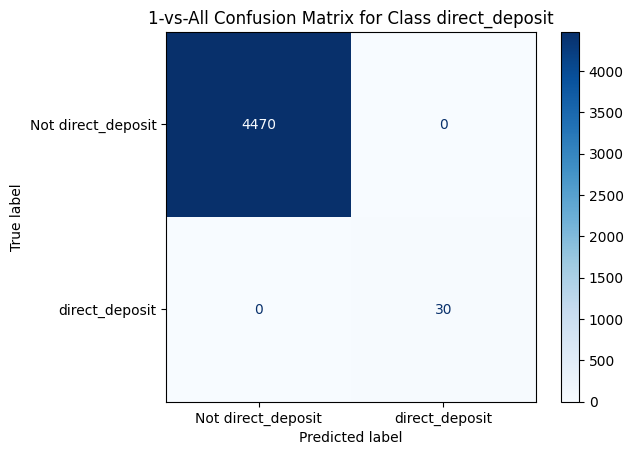

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

#  F1 scores from the classification report
report = classification_report(y_test, y_test_pred, output_dict=True)
f1_scores = {label: metrics['f1-score'] for label, metrics in report.items()if label not in ['accuracy', 'macro avg', 'weighted avg']}
# Find the classes with the best and worst F1 scores
best_class = max(f1_scores, key=f1_scores.get)
worst_class = min(f1_scores, key=f1_scores.get)

# Compute and display 1-vs-all confusion matrix
def plot_1_vs_all_confusion_matrix(y_true, y_pred, target_class, class_name):
    # Create binary labels for the target class (1 for target class, 0 for others)
    # This is because our classes are strings, and confusion matrix display expects integers.
    y_true_binary = (y_true == target_class).astype(int)
    y_pred_binary = (y_pred == target_class).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + class_name, class_name])
    display.plot(cmap="Blues")
    plt.title(f"1-vs-All Confusion Matrix for Class {class_name}")
    plt.show()

# Plot for the best F1 class
plot_1_vs_all_confusion_matrix(y_test, y_test_pred, target_class=best_class, class_name=best_class)




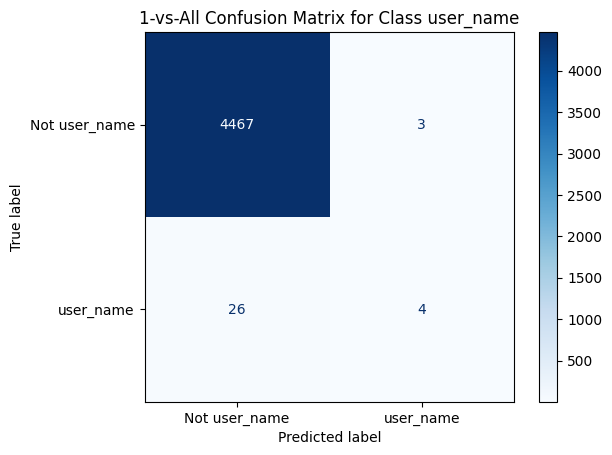

In [40]:
# Plot for the worst F1 class
plot_1_vs_all_confusion_matrix(y_test, y_test_pred, target_class=worst_class, class_name=worst_class)

As we increase the alpha, the validation accuracy decreases. Naive Bayes accuracy on validation set is 80 percent, which is higher than expected for a generative model. Let us try some discriminative models:

### Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the validation dataset
lr_val_predictions = model.predict(X_val)

# Evaluate the accuracy
lr_val_accuracy = accuracy_score(y_val, lr_val_predictions)
print(f"Logistic Regression Validation Accuracy: {lr_val_accuracy:.4f}")

# Print  classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_val, lr_val_predictions))


Logistic Regression Validation Accuracy: 0.8097
Classification Report for Logistic Regression:
                           precision    recall  f1-score   support

      accept_reservations       0.75      0.60      0.67        20
          account_blocked       0.71      0.85      0.77        20
                    alarm       1.00      0.95      0.97        20
       application_status       0.86      0.95      0.90        20
                      apr       1.00      0.95      0.97        20
            are_you_a_bot       0.94      0.80      0.86        20
                  balance       0.73      0.80      0.76        20
             bill_balance       0.79      0.55      0.65        20
                 bill_due       0.44      0.35      0.39        20
              book_flight       0.84      0.80      0.82        20
               book_hotel       0.83      0.75      0.79        20
               calculator       0.82      0.70      0.76        20
                 calendar       0

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 17,  0, ...,  0,  0,  0],
       [ 0,  0, 19, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 17,  0,  0],
       [ 0,  0,  0, ...,  1, 15,  0],
       [ 0,  0,  0, ...,  0,  1, 13]])

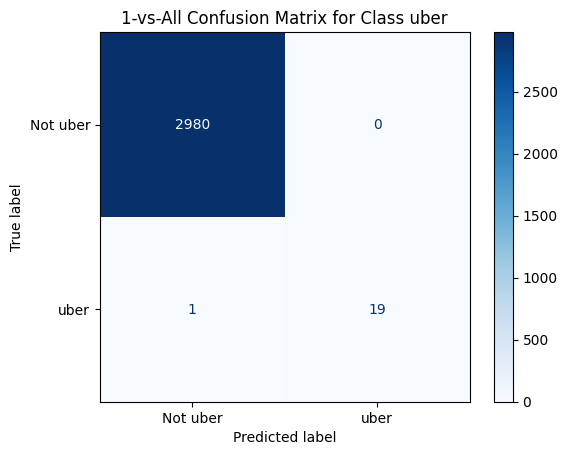

In [43]:
# Plot for the worst F1 class
plot_1_vs_all_confusion_matrix(y_val, lr_val_predictions, target_class='uber', class_name='uber')

In [44]:
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_val, lr_val_predictions)

# Sum of off-diagonal elements for each class 
misclassifications = np.sum(cm, axis=1) - np.diag(cm)

# Find the most confused class
most_confused_class_index = np.argmax(misclassifications)
most_confused_class = most_confused_class_index 

print(f"Most confused class: {most_confused_class}")
print(f"Number of misclassifications for this class: {misclassifications[most_confused_class]}")


Most confused class: 24
Number of misclassifications for this class: 19


#### Hyperparameter tuning for LR

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define class weights
classes = np.unique(y_train)
class_weights = {cls: 1 for cls in classes}  # Initialize all weights to 1
class_weights[24] = 2  # We focused on class 24, because it was the most confused class

# Define parameter distribution for CV search
param_dist = {
    "dual": [True,False],  
    "C": [0.5, 1, 1.5, 4]  
}

# Initialize Logistic Regression model
lr = LogisticRegression(solver='lbfgs',max_iter=1000, random_state=42, multi_class="multinomial")

# Set up RandomizedSearchCV
random_cv = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=8,              # Number of random combinations to test, 4 x 2 in our case
    cv=5,                   # 5-fold cross-validation
    scoring="accuracy",     # Optimize for accuracy
    random_state=42,        # For reproducibility 
    verbose=1,              # Print the progress
    n_jobs=-1               # Use all available cores
)

# Perform random search
random_cv.fit(X_train, y_train)

# Extract best parameters and score
print(f"Best Parameters: {random_cv.best_params_}")
print(f"Best Validation Accuracy: {random_cv.best_score_:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [31]:
#now use the best hyperparameters for LR
best_model=random_cv.best_estimator_
best_model.fit(X_train,y_train)

y_val_pred=best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report on Validation Dataset:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8287
Classification Report on Validation Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.75      0.60      0.67        20
          account_blocked       0.72      0.90      0.80        20
                    alarm       1.00      0.95      0.97        20
       application_status       0.90      0.95      0.93        20
                      apr       1.00      1.00      1.00        20
            are_you_a_bot       0.90      0.90      0.90        20
                  balance       0.80      0.80      0.80        20
             bill_balance       0.85      0.55      0.67        20
                 bill_due       0.42      0.50      0.45        20
              book_flight       0.90      0.90      0.90        20
               book_hotel       0.85      0.85      0.85        20
               calculator       0.74      0.70      0.72        20
                 calendar       0.94      0.75      0.8

In [33]:
from sklearn.metrics import confusion_matrix
##now prediction for test set
y_test_pred=best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report on Test Dataset:")
print(classification_report(y_test, y_test_pred))
confusion_matrix(y_test,y_test_pred)

Test Accuracy: 0.8271
Classification Report on Test Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.81      0.87      0.84        30
          account_blocked       0.69      0.83      0.76        30
                    alarm       0.97      0.97      0.97        30
       application_status       0.94      1.00      0.97        30
                      apr       0.97      1.00      0.98        30
            are_you_a_bot       0.83      0.97      0.89        30
                  balance       0.76      0.73      0.75        30
             bill_balance       0.66      0.63      0.64        30
                 bill_due       0.44      0.40      0.42        30
              book_flight       0.96      0.77      0.85        30
               book_hotel       0.91      1.00      0.95        30
               calculator       0.92      0.73      0.81        30
                 calendar       0.67      0.60      0.63        30


array([[26,  0,  0, ...,  0,  0,  0],
       [ 0, 25,  0, ...,  0,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       ...,
       [ 1,  0,  0, ..., 20,  1,  0],
       [ 0,  0,  0, ...,  0, 19,  0],
       [ 0,  0,  0, ...,  0,  0, 16]])

### Support Vector Machine (SVM)

In [34]:
from sklearn.svm import LinearSVC

# Initialize the SVM classifier
linear_svm_model = LinearSVC(max_iter=1000, random_state=42)
# Train the model
linear_svm_model.fit(X_train, y_train)
# Predict on the validation dataset
linear_svm_val_predictions = linear_svm_model.predict(X_val)
# Evaluate the accuracy
linear_svm_val_accuracy = accuracy_score(y_val, linear_svm_val_predictions)
print(f"Linear SVM Validation Accuracy: {linear_svm_val_accuracy:.4f}")


# SVC with linear kernel
svc_model = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)
svc_model.fit(X_train, y_train) # Train
svc_val_predictions = svc_model.predict(X_val) # Predict on validation set
print(f"SVC Validation Accuracy: {accuracy_score(y_val, svc_val_predictions):.4f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVM Validation Accuracy: 0.8240
SVC Validation Accuracy: 0.8143


#### Hyperparameter tuning

In [35]:
##For linearSVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    "max_iter": [1000, 2000, 5000]  # Number of iterations
}

# Initialize LinearSVC model
linear_svm_model = LinearSVC(random_state=42)

# Set up GridSearchCV
grid_cv = GridSearchCV(
    estimator=linear_svm_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Perform grid search on training data
grid_cv.fit(X_train, y_train)

# Best parameters and validation accuracy
print(f"Best Parameters for LinearSVC: {grid_cv.best_params_}")
print(f"Best Validation Accuracy for LinearSVC: {grid_cv.best_score_:.4f}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/

Best Parameters for LinearSVC: {'C': 1, 'max_iter': 1000}
Best Validation Accuracy for LinearSVC: 0.8293


In [36]:
#now use the best hyperparameters
best_model=grid_cv.best_estimator_
best_model.fit(X_train,y_train)

y_val_pred=best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report on Validation Dataset:")
print(classification_report(y_val, y_val_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Validation Accuracy: 0.8240
Classification Report on Validation Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.80      0.60      0.69        20
          account_blocked       0.89      0.80      0.84        20
                    alarm       1.00      1.00      1.00        20
       application_status       0.90      0.95      0.93        20
                      apr       1.00      1.00      1.00        20
            are_you_a_bot       0.90      0.90      0.90        20
                  balance       0.87      0.65      0.74        20
             bill_balance       0.80      0.60      0.69        20
                 bill_due       0.53      0.40      0.46        20
              book_flight       0.93      0.65      0.76        20
               book_hotel       0.94      0.75      0.83        20
               calculator       0.82      0.70      0.76        20
                 calendar       0.92      0.60      0.7

In [37]:
from sklearn.metrics import confusion_matrix
##now prediction for test set
y_test_pred=best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report on Test Dataset:")
print(classification_report(y_test, y_test_pred))
confusion_matrix(y_test,y_test_pred)

Test Accuracy: 0.8229
Classification Report on Test Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.81      0.87      0.84        30
          account_blocked       0.71      0.73      0.72        30
                    alarm       0.97      0.97      0.97        30
       application_status       0.88      1.00      0.94        30
                      apr       0.97      1.00      0.98        30
            are_you_a_bot       0.83      1.00      0.91        30
                  balance       0.75      0.70      0.72        30
             bill_balance       0.62      0.67      0.65        30
                 bill_due       0.58      0.37      0.45        30
              book_flight       0.92      0.77      0.84        30
               book_hotel       0.97      1.00      0.98        30
               calculator       0.96      0.73      0.83        30
                 calendar       0.71      0.57      0.63        30


array([[26,  0,  0, ...,  0,  0,  0],
       [ 0, 22,  0, ...,  1,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 21,  1,  0],
       [ 0,  0,  0, ...,  0, 19,  0],
       [ 0,  0,  0, ...,  0,  0, 16]])

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training dataset
rf_model.fit(X_train, y_train)

# Predict on the validation dataset
rf_val_predictions = rf_model.predict(X_val)

# Evaluate the accuracy
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
print(f"Random Forest Validation Accuracy: {rf_val_accuracy:.4f}")



Random Forest Validation Accuracy: 0.7990


#### Hyperparameter Tuning

In [40]:

param_grid = {
   
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
}

grid_cv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)
grid_cv.fit(X_train, y_train)

print(f"Best Parameters: {grid_cv.best_params_}")
print(f"Best Validation Accuracy: {grid_cv.best_score_:.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 5}
Best Validation Accuracy: 0.8158


In [41]:
#now use the best hyperparameters
best_model=grid_cv.best_estimator_
best_model.fit(X_train,y_train)

y_val_pred=best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report on Validation Dataset:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7993
Classification Report on Validation Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.71      0.60      0.65        20
          account_blocked       0.86      0.90      0.88        20
                    alarm       1.00      0.95      0.97        20
       application_status       0.83      0.95      0.88        20
                      apr       1.00      1.00      1.00        20
            are_you_a_bot       0.88      0.75      0.81        20
                  balance       0.71      0.75      0.73        20
             bill_balance       0.69      0.55      0.61        20
                 bill_due       0.43      0.45      0.44        20
              book_flight       0.94      0.75      0.83        20
               book_hotel       0.81      0.85      0.83        20
               calculator       0.73      0.80      0.76        20
                 calendar       0.83      0.75      0.7

In [42]:
from sklearn.metrics import confusion_matrix
##now prediction for test set
y_test_pred=best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report on Test Dataset:")
print(classification_report(y_test, y_test_pred))
confusion_matrix(y_test,y_test_pred)

Test Accuracy: 0.8082
Classification Report on Test Dataset:
                           precision    recall  f1-score   support

      accept_reservations       0.87      0.87      0.87        30
          account_blocked       0.61      0.83      0.70        30
                    alarm       0.94      0.97      0.95        30
       application_status       0.91      1.00      0.95        30
                      apr       0.96      0.80      0.87        30
            are_you_a_bot       0.83      0.97      0.89        30
                  balance       0.59      0.77      0.67        30
             bill_balance       0.67      0.73      0.70        30
                 bill_due       0.37      0.33      0.35        30
              book_flight       0.94      0.53      0.68        30
               book_hotel       0.91      1.00      0.95        30
               calculator       0.75      0.70      0.72        30
                 calendar       0.68      0.63      0.66        30


array([[26,  0,  0, ...,  0,  0,  0],
       [ 0, 25,  0, ...,  0,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 20,  2,  0],
       [ 0,  0,  0, ...,  0, 19,  0],
       [ 0,  0,  0, ...,  0,  0, 13]])

### XGBoost

To pass into the XGBoost classifier, we first need to encode the labels.


In [43]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the training labels and transform
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

In [48]:

from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='multi:softmax', num_class=150, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train_encoded)

# Predict on the validation dataset
xgb_val_predictions = xgb_model.predict(X_val)

# Evaluate the accuracy
xgb_val_accuracy = accuracy_score(y_val_encoded, xgb_val_predictions)
print(f"XGBoost Validation Accuracy: {xgb_val_accuracy:.4f}")


XGBoost Validation Accuracy: 0.7377


In [49]:
from sklearn.metrics import classification_report

# Use encoded labels for classification report
print("Classification Report for XGBoost:")
print(classification_report(y_val_encoded, xgb_val_predictions))


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        20
           1       0.78      0.90      0.84        20
           2       0.94      0.80      0.86        20
           3       0.86      0.95      0.90        20
           4       1.00      0.95      0.97        20
           5       0.85      0.55      0.67        20
           6       0.84      0.80      0.82        20
           7       0.69      0.55      0.61        20
           8       0.53      0.40      0.46        20
           9       1.00      0.70      0.82        20
          10       0.80      0.80      0.80        20
          11       0.89      0.40      0.55        20
          12       0.73      0.55      0.63        20
          13       0.74      0.85      0.79        20
          14       1.00      1.00      1.00        20
          15       0.62      0.80      0.70        20
          16       0.79      0.95      0.86   

### Neural Networks Architecture

In [51]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.0 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [59]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)  # Transform validation labels
y_test_encoded = encoder.transform(y_test)  # Transform test labels 


In [60]:
# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(151, activation='softmax')  # Number of classes 150
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val, y_val_encoded))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3585 - loss: 4.5328 - val_accuracy: 0.7540 - val_loss: 1.9497
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8210 - loss: 1.3770 - val_accuracy: 0.8063 - val_loss: 0.9826
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8931 - loss: 0.6198 - val_accuracy: 0.8263 - val_loss: 0.7801
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9264 - loss: 0.3952 - val_accuracy: 0.8307 - val_loss: 0.7098
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9385 - loss: 0.2941 - val_accuracy: 0.8317 - val_loss: 0.6809
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9486 - loss: 0.2311 - val_accuracy: 0.8317 - val_loss: 0.6734
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9533 - loss: 0.1942 - val_accuracy: 0.8330 - val_loss: 0.6639
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9584 - loss: 0.1720 - val_accuracy: 0.

In [64]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Define the model-building function for KerasTuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=64),
        activation=hp.Choice('activation', ['relu', 'tanh'])
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(len(encoder.classes_), activation='softmax'))  # Number of classes based on encoding
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='nn_tuning'
)

# Run the search with encoded labels
tuner.search(
    X_train, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_encoded),
    verbose=1
)


Trial 20 Complete [00h 00m 16s]
val_accuracy: 0.34966665506362915

Best val_accuracy So Far: 0.8376666903495789
Total elapsed time: 00h 08m 48s


In [67]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best units: {best_hps.get('units')}
Best activation: {best_hps.get('activation')}
Best dropout rate: {best_hps.get('dropout')}
Best optimizer: {best_hps.get('optimizer')}
""")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train, y_train_encoded,
    epochs=20,                           
    batch_size=32,
    validation_data=(X_val, y_val_encoded),
    verbose=1
)



Best units: 448
Best activation: tanh
Best dropout rate: 0.30000000000000004
Best optimizer: adam

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5458 - loss: 4.1670 - val_accuracy: 0.7790 - val_loss: 1.2805
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8773 - loss: 0.7998 - val_accuracy: 0.8247 - val_loss: 0.7779
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9305 - loss: 0.3677 - val_accuracy: 0.8353 - val_loss: 0.6845
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9473 - loss: 0.2391 - val_accuracy: 0.8330 - val_loss: 0.6690
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9565 - loss: 0.1840 - val_accuracy: 0.8280 - val_loss: 0.6666
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9611 - loss: 0.1486 - val_accuracy: 0.8303 - val_loss: 0.6701
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9655 - loss: 0.1244 - val_accuracy: 0.8290 - val_loss: 0.6838
Epoc

In [68]:
# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8041 - loss: 0.8593  
Test Accuracy: 0.8138


In [69]:
y_test_pred = model.predict(X_test)
y_test_pred_classes = y_test_pred.argmax(axis=1)  # Get the class with the highest probability
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)
print(f"Test Accuracy: {test_accuracy}")
# Classification report
print(classification_report(y_test_encoded, y_test_pred_classes))

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
Test Accuracy: 0.8384444444444444
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.71      0.80      0.75        30
           2       0.94      0.97      0.95        30
           3       0.97      1.00      0.98        30
           4       0.97      1.00      0.98        30
           5       0.75      1.00      0.86        30
           6       0.74      0.77      0.75        30
           7       0.62      0.67      0.65        30
           8       0.45      0.60      0.51        30
           9       1.00      0.87      0.93        30
          10       1.00      1.00      1.00        30
          11       0.53      0.77      0.63        30
          12       0.75      0.60      0.67        30
          13       0.76      0.83      0.79        30
          14       1.00      0.97      0.98        30
          15       0.72      0.97      0.83        30
    

# Feature Extraction Method 2: FastText 

So far we implemented feature extraction using TF-IDF. Now we will implement a dense embeddings, FastText, to see that if this changes the accuracy.

In [12]:
!pip install fasttext-wheel
import fasttext


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


The full data was already loaded, let us recall that.

In [13]:
full_in_scope_dataframe.head()

,query,intent,scope,split
0,what expression would i use to say i love you ...,translate,in-scope,train
1,can you tell me how to say 'i do not speak muc...,translate,in-scope,train
2,"what is the equivalent of, 'life is good' in f...",translate,in-scope,train
3,"tell me how to say, 'it is a beautiful morning...",translate,in-scope,train
4,"if i were mongolian, how would i say that i am...",translate,in-scope,train


Following the tutorials: https://pypi.org/project/fasttext/#installation and https://fasttext.cc/docs/en/supervised-tutorial.html we've seen that a specific preprocessing is needed for using FastText.

![alt text](image.png)

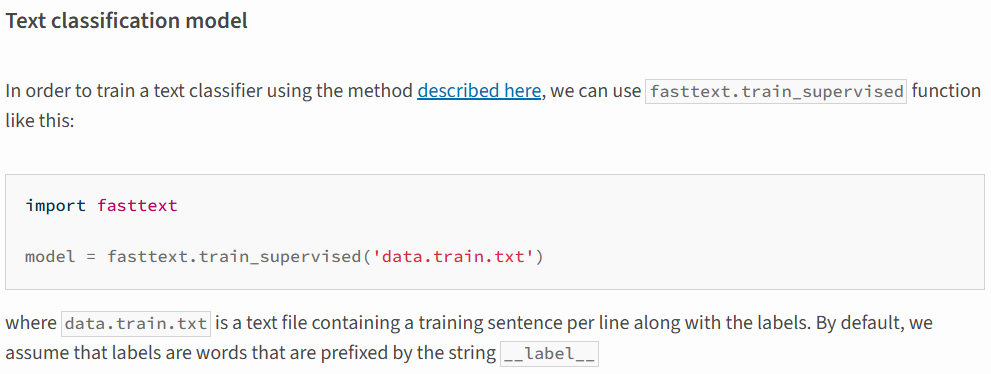

In [14]:
# Getting only the required fields
train_data_minimal = train_data[['query', 'intent']].copy()
validation_data_minimal = validation_data[['query', 'intent']].copy()
test_data_minimal = test_data[['query', 'intent']].copy()


In [15]:
# Adding a prefix "__label__" to the 'intent' column
train_data_minimal['intent'] = '__label__' + train_data_minimal['intent']
validation_data_minimal['intent'] = '__label__' + validation_data_minimal['intent']
test_data_minimal['intent'] = '__label__' + test_data_minimal['intent']


In [16]:
train_data_minimal.head()

,query,intent
0,what expression would i use to say i love you ...,__label__translate
1,can you tell me how to say 'i do not speak muc...,__label__translate
2,"what is the equivalent of, 'life is good' in f...",__label__translate
3,"tell me how to say, 'it is a beautiful morning...",__label__translate
4,"if i were mongolian, how would i say that i am...",__label__translate


In [17]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bilaldertli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:

train_data_minimal_tokenized = pd.DataFrame()

# Copy the `intent` column from the original DataFrame
train_data_minimal_tokenized['intent'] = train_data_minimal['intent']
# Tokenize and convert back to string
train_data_minimal_tokenized['query'] = train_data_minimal['query'].apply(
    lambda x: ' '.join(word_tokenize(x))
)

#Repeat for validation and test data

validation_data_minimal_tokenized = pd.DataFrame()

# Copy the `intent` column from the original DataFrame
validation_data_minimal_tokenized['intent'] = validation_data_minimal['intent']
# Tokenize and convert back to string
validation_data_minimal_tokenized['query'] = validation_data_minimal['query'].apply(
    lambda x: ' '.join(word_tokenize(x))
)


test_data_minimal_tokenized = pd.DataFrame()

# Copy the `intent` column from the original DataFrame
test_data_minimal_tokenized['intent'] = test_data_minimal['intent']
# Tokenize and convert back to string
test_data_minimal_tokenized['query'] = test_data_minimal['query'].apply(
    lambda x: ' '.join(word_tokenize(x))
)




In [19]:
print(train_data_minimal_tokenized.shape)
print(validation_data_minimal_tokenized.shape)
print(test_data_minimal_tokenized.shape)


(15000, 2)
(3000, 2)
(4500, 2)


In [20]:
print(train_data_minimal.shape)
print(validation_data_minimal.shape)
print(test_data_minimal.shape)


(15000, 2)
(3000, 2)
(4500, 2)


In [21]:
train_data_minimal.head() #fields: query, intent; with prefix __label


,query,intent
0,what expression would i use to say i love you ...,__label__translate
1,can you tell me how to say 'i do not speak muc...,__label__translate
2,"what is the equivalent of, 'life is good' in f...",__label__translate
3,"tell me how to say, 'it is a beautiful morning...",__label__translate
4,"if i were mongolian, how would i say that i am...",__label__translate


### Data Preparation and Preprocessing

In [22]:
import os

directory = 'fasttextdata'
if not os.path.exists(directory):
    os.makedirs(directory)

# Create the file path using os.path.join for compatibility
train_file_path = os.path.join(directory, 'traindata.txt')
validation_file_path = os.path.join(directory, 'validationdata.txt')
test_file_path = os.path.join(directory, 'testdata.txt')
train_validation_combined_file_path = os.path.join(directory, 'trainandvalidationdata.txt')
tokenized_train_file_path = os.path.join(directory, 'tokenizedtraindata.txt')
tokenized_validation_file_path = os.path.join(directory, 'tokenizedvalidationdata.txt')
tokenized_test_file_path = os.path.join(directory, 'tokenizedtestdata.txt')
tokenized_train_validation_combined_file_path = os.path.join(directory, 'tokenizedtrainandvalidationdata.txt')



# Open file in write mode
with open(train_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in train_data_minimal.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)

# Open file in write mode
with open(validation_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in validation_data_minimal.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)

# Open file in write mode
with open(train_validation_combined_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in train_data_minimal.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)
    for index, row in validation_data_minimal.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)


# Open file in write mode
with open(test_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in test_data_minimal.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)


#Doing the same for tokenized


# Open file in write mode
with open(tokenized_train_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in train_data_minimal_tokenized.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)

# Open file in write mode
with open(tokenized_validation_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in validation_data_minimal_tokenized.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)


# Open file in write mode
with open(tokenized_train_validation_combined_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in train_data_minimal_tokenized.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)
    for index, row in validation_data_minimal_tokenized.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)

# Open file in write mode
with open(tokenized_test_file_path, 'w', encoding='utf-8') as f:
    # Iterate through each row
    for index, row in test_data_minimal_tokenized.iterrows():
        # Format: __label__intent query
        line = f'{row["intent"]} {row["query"]}\n'
        f.write(line)


In [51]:
model = fasttext.train_supervised(input=train_file_path)

In [52]:
# An example from validation dataset, which is predicted true.
model.predict('how long is it going to take me to get to bellevue')

(('__label__distance',), array([0.7185058]))

In [53]:
def saveModelWithName(modelName):
    
    directory = 'fastTextModel'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Create the file path using os.path.join for cross-platform compatibility
    file_path = os.path.join(directory, f'{modelName}.bin')
    return file_path


# Save the model for future use
model.save_model(saveModelWithName('model1'))

### Hyperparameter Tuning
Let us also train a second model with 25 epochs. Default epoch is 5.

In [54]:
model2 = fasttext.train_supervised(input=train_file_path, epoch=25)
model2.save_model(saveModelWithName('model2'))

In [55]:
model3 = fasttext.train_supervised(input=train_file_path, epoch=50)
model3.save_model(saveModelWithName('model3'))

In [56]:
model4 = fasttext.train_supervised(input=train_file_path, epoch=50, wordNgrams=2)
model4.save_model(saveModelWithName('model4'))

In [57]:
model5 = fasttext.train_supervised(input=train_file_path, epoch=50, lr=1.0)
model5.save_model(saveModelWithName('model5'))

In [58]:
model6 = fasttext.train_supervised(input=tokenized_train_file_path, epoch=50, lr=1.0)
model6.save_model(saveModelWithName('model6'))

Now we can test the accuracy on the validation data. Unfortunately, fasttext does not provide F1 score and accuracy metrics. The triplets printed are the number of instances (3000), precision, and recall.

In [59]:
model.test(validation_file_path) #Pretty bad score, but this is base model!

(3000, 0.369, 0.369)

Let us calculate accuracy and F1 scores as well by using Scikit-learn.

In [60]:
from sklearn.metrics import accuracy_score, f1_score
def accuracyTest(model_name, model, validation_file_path):
    """
    Calculate the accuracy and F1 score of a FastText model on a validation dataset.

    Parameters:
        model_name (str): Name of the model being evaluated. We can name the model as we wish.
        model: The FastText model object. Since we train different models, we want to test their accuracy.
        validation_file_path (str): Path to the validation dataset file. In our case this will be the same for all models.

    Returns:
        dict: A dictionary containing accuracy and F1 score, best and worst accuracy classes.
    """
    true_labels = []
    predicted_labels = []

    # Read the validation file
    with open(validation_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Each line is in the format: "__label__intent query"
            parts = line.strip().split(' ', 1)
            true_label = parts[0]  # The label is the first part
            query = parts[1] if len(parts) > 1 else ""  # The query is the rest
            true_labels.append(true_label)

            # Predict the label using the FastText model
            prediction = model.predict(query)[0][0]  # Get the top predicted label
            predicted_labels.append(prediction)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate F1 score 
    f1 = f1_score(true_labels, predicted_labels, average='macro')   
    
   # Print results
    print(f"Results for Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")


Now we can easily call our models to test their accuracy.

In [61]:
accuracyTest("Base Model", model, validation_file_path)
print("--"*50)
accuracyTest("25 epochs", model2, validation_file_path)
print("--"*50)
accuracyTest("50 epochs", model3, validation_file_path)
print("--"*50)
accuracyTest("50 epochs and 2-grams", model4, validation_file_path)
print("--"*50)
accuracyTest("50 epochs and 1.0 learning rate", model5, validation_file_path)
print("--"*50)
accuracyTest("Tokenized 50 epochs and 1.0 learning rate", model6, tokenized_validation_file_path)




Results for Model: Base Model
Accuracy: 0.3690
F1 Score (Macro): 0.3286
----------------------------------------------------------------------------------------------------
Results for Model: 25 epochs
Accuracy: 0.8707
F1 Score (Macro): 0.8708
----------------------------------------------------------------------------------------------------
Results for Model: 50 epochs
Accuracy: 0.8843
F1 Score (Macro): 0.8848
----------------------------------------------------------------------------------------------------
Results for Model: 50 epochs and 2-grams
Accuracy: 0.8777
F1 Score (Macro): 0.8774
----------------------------------------------------------------------------------------------------
Results for Model: 50 epochs and 1.0 learning rate
Accuracy: 0.8777
F1 Score (Macro): 0.8778
----------------------------------------------------------------------------------------------------
Results for Model: Tokenized 50 epochs and 1.0 learning rate
Accuracy: 0.8917
F1 Score (Macro): 0.8903


Let us test accuracy on the test data, with using the best performing hyperparameters.

In [63]:
accuracyTest("Tokenized Best Model with Test Data", model6, tokenized_test_file_path) # Test on test

Results for Model: Tokenized Best Model with Test Data
Accuracy: 0.8940
F1 Score (Macro): 0.8935


In [64]:
final_model = fasttext.train_supervised(input=tokenized_train_validation_combined_file_path, epoch=50, lr=1.0) # Train on training + validation
final_model.save_model(saveModelWithName('final_model'))
accuracyTest("Tokenized Best Model with Test Data", final_model, tokenized_test_file_path) # Test on test

Results for Model: Tokenized Best Model with Test Data
Accuracy: 0.9007
F1 Score (Macro): 0.9002


Test set accuracy with fasttext is around 90 percen!. Considering the training time, this is very impressive, it just takes around 10 seconds to train and has almost 90 percent accuracy on a 150-class classification task.

# Trying BERT Embeddings 

Following the approach of the paper, we used RoBERTa-base for classification as well. We used Kaggle's P100 GPU for training. Note that here we are loading the dataset using Huggingface interface, however, we preprocess it in the same way so that the test environment is stable. In the end, the training - validation - test datasets are all the same.

In [1]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict

In [2]:
dataset = load_dataset("clinc/clinc_oos", "plus")
def filter_intent(example):
    return example['intent'] != 42

# Apply the filter function to each split to remove OOS queries
dataset = DatasetDict({
    split: dataset[split].filter(filter_intent)
    for split in dataset
})
# Now we need to update the labels so that our model does not give an error. 
def update_intent(example):
    if example['intent'] == 150:
        example['intent'] = 42
    return example

dataset = DatasetDict({
    split: dataset[split].map(update_intent)
    for split in dataset
})
dataset

README.md:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15250 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5500 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 4500
    })
})

In [3]:
dataset['train'] = dataset['train'].rename_column('intent', 'label')
dataset['validation'] = dataset['validation'].rename_column('intent', 'label')
dataset['test'] = dataset['test'].rename_column('intent', 'label')

In [4]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [6]:
keep_columns = ["input_ids", "attention_mask", "label"]
dataset.set_format("numpy", columns=keep_columns)

In [7]:
BATCH_SIZE = 16

def to_tf_dataset(hf_dataset, shuffle=False):
    """Convert a Hugging Face Dataset split into a tf.data.Dataset (features, label)."""
    input_ids = hf_dataset["input_ids"]
    attention_mask = hf_dataset["attention_mask"]
    labels = hf_dataset["label"]

   
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            
        },
        labels
    ))

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(BATCH_SIZE)
    return ds

train_tf_dataset = to_tf_dataset(dataset["train"], shuffle=True)
val_tf_dataset   = to_tf_dataset(dataset["validation"], shuffle=False)
test_tf_dataset  = to_tf_dataset(dataset["test"], shuffle=False)


In [8]:
num_labels=150
lr=1e-5
num_epochs=40
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels
)
# AdamW from tensorflow
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=0.01)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Setting up the training arguments - may be changed according to the needs

In [9]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

We will use accuracy as a metric, setting it as the load metric.

In [10]:
# Train
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=num_epochs
)

Epoch 1/40
938/938 [==============================] - 560s 553ms/step - loss: 3.6701 - accuracy: 0.5438 - val_loss: 2.1028 - val_accuracy: 0.8530
Epoch 2/40
938/938 [==============================] - 516s 550ms/step - loss: 1.5350 - accuracy: 0.9222 - val_loss: 0.7672 - val_accuracy: 0.9407
Epoch 3/40
938/938 [==============================] - 516s 550ms/step - loss: 0.5926 - accuracy: 0.9732 - val_loss: 0.3707 - val_accuracy: 0.9593
Epoch 4/40
938/938 [==============================] - 516s 551ms/step - loss: 0.2606 - accuracy: 0.9882 - val_loss: 0.2464 - val_accuracy: 0.9650
Epoch 5/40
938/938 [==============================] - 515s 549ms/step - loss: 0.1398 - accuracy: 0.9926 - val_loss: 0.1931 - val_accuracy: 0.9677
Epoch 6/40
938/938 [==============================] - 514s 548ms/step - loss: 0.0860 - accuracy: 0.9938 - val_loss: 0.1624 - val_accuracy: 0.9723
Epoch 7/40
938/938 [==============================] - 515s 549ms/step - loss: 0.0582 - accuracy: 0.9951 - val_loss: 0.1604 -

Initialize the Trainer and Train the Model: Set up the Trainer and start training:

In [11]:
model.evaluate(test_tf_dataset)

282/282 [==============================] - 50s 178ms/step - loss: 0.2347 - accuracy: 0.9622


[0.23474207520484924, 0.9622222185134888]

As expected, contextual embeddings outperforms our previous models. Note that the fine-tuning of RoBERTa-base with P100 GPU took 6 hours.

## Using static embeddings, our best model was using Dense Embedding approach of FastText, with an accuracy of 89.7 percent. Here, we reached a new level: 96.22 percent accuracy. 

In [ ]:
OUTPUT_DIR = "my_roberta_base_model_40_epoches" # We save the model so that we can use it later, without needing to fine-tune again :)

# 1) Save the trained model & tokenizer
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

#### Save the model for future use, without needing training again

In [12]:
output_dir = "/kaggle/working/fine_tuned_roberta"

# Save model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to /kaggle/working/fine_tuned_roberta


In [13]:
import shutil

shutil.make_archive("fine_tuned_roberta", 'zip', output_dir)
print("Zipped model saved as fine_tuned_roberta.zip")


Zipped model saved as fine_tuned_roberta.zip


# Comparing Results: RoBERTa-base, FastText, and NaiveBayes

In [1]:
from datasets import load_dataset, DatasetDict
dataset = load_dataset("clinc/clinc_oos", "plus")
def filter_intent(example):
    return example['intent'] != 42

# Apply the filter function to each split to remove OOS queries
dataset = DatasetDict({
    split: dataset[split].filter(filter_intent)
    for split in dataset
})
# Now we need to update the labels so that our model does not give an error. 
def update_intent(example):
    if example['intent'] == 150:
        example['intent'] = 42
    return example

dataset = DatasetDict({
    split: dataset[split].map(update_intent)
    for split in dataset
})
dataset
dataset['train'] = dataset['train'].rename_column('intent', 'label')
dataset['validation'] = dataset['validation'].rename_column('intent', 'label')
dataset['test'] = dataset['test'].rename_column('intent', 'label')

README.md:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15250 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5500 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [2]:
# We will load the model directly, no need to re-train
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Specify the directory where the model files are located
model_directory = "/kaggle/working/fine_tuned_roberta"

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_directory, from_tf=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory, from_tf=True)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [3]:
import tensorflow as tf
import numpy as np
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization to the dataset
dataset = dataset.map(tokenize, batched=True)

# Set the format and specify which columns to keep
keep_columns = ["input_ids", "attention_mask", "label"]
dataset.set_format("numpy", columns=keep_columns)

# Define batch size
BATCH_SIZE = 16

# Function to convert HF dataset to TF dataset
def to_tf_dataset(hf_dataset, shuffle=False):
    """Convert a Hugging Face Dataset split into a tf.data.Dataset (features, label)."""
    input_ids = hf_dataset["input_ids"]
    attention_mask = hf_dataset["attention_mask"]
    labels = hf_dataset["label"]
    
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        },
        labels
    ))
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(BATCH_SIZE)
    return ds

# Create TF datasets
train_tf_dataset = to_tf_dataset(dataset["train"], shuffle=True)
val_tf_dataset = to_tf_dataset(dataset["validation"], shuffle=False)
test_tf_dataset = to_tf_dataset(dataset["test"], shuffle=False)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [8]:
import json

def save_results_to_json(results, filepath):
    """
    Convert evaluation results to JSON-serializable format and save to file.
    
    Args:
        results: Dictionary containing evaluation metrics and confusion matrices
        filepath: Path where to save the JSON file
    """
    # Create a copy of results to avoid modifying the original one
    json_results = {}
    
    # Convert basic metrics
    json_results['accuracy'] = float(results['accuracy'])
    json_results['f1_macro'] = float(results['f1_macro'])
    json_results['precision_macro'] = float(results['precision_macro'])
    json_results['recall_macro'] = float(results['recall_macro'])
    
    # Convert full confusion matrix 
    json_results['full_confusion_matrix'] = results['full_confusion_matrix'].tolist()
    
    # Convert selected confusion matrices
    json_results['selected_confusion_matrices'] = {
        class_type: {
            'class_id': int(info['class_id']),
            'accuracy': float(info['accuracy']),
            'confusion_matrix': info['confusion_matrix'].tolist()
        }
        for class_type, info in results['selected_confusion_matrices'].items()
    }
    
    # Convert class accuracies
    json_results['class_accuracies'] = [
        {'class_id': int(class_id), 'accuracy': float(acc)}
        for class_id, acc in results['class_accuracies']
    ]
    
    # Save to file 
    with open(filepath, 'w') as f:
        json.dump(json_results, f, indent=4)
    
    print(f"Results saved to {filepath}")

# Call the function to store results
save_results_to_json(metrics, 'model_evaluation_results.json')

Results saved to model_evaluation_results.json


Plotting Functions

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_binary_confusion_matrix(cm, title=None, figsize=(8, 6)):
    """
    Plot a binary confusion matrix with percentages and absolute numbers.
    
    Args:
        cm: 2x2 confusion matrix array
        title: Title for the plot
        figsize: Size of the figure (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Calculate percentages
    cm_sum = np.sum(cm)
    cm_percentages = cm / cm_sum * 100
    
    # Create annotation text with both percentage and absolute numbers
    annot = np.array([[f'{cm_percentages[i, j]:.1f}%\n({cm[i, j]})' 
                       for j in range(2)] for i in range(2)])
    
    # Create heatmap
    sns.heatmap(cm_percentages, annot=annot, fmt='', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'],
                cbar_kws={'label': 'Percentage'})
    
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_single_class_from_full_cm(full_cm, class_idx, num_surrounding=2, figsize=(10, 8)):
    """
    Plot confusion matrix for a specific class and its surrounding classes.
    
    Args:
        full_cm: Full confusion matrix array
        class_idx: Index of the class to focus on
        num_surrounding: Number of surrounding classes to include on each side
        figsize: Size of the figure (width, height)
    """
    # Calculate the range of classes to show
    start_idx = max(0, class_idx - num_surrounding)
    end_idx = min(full_cm.shape[0], class_idx + num_surrounding + 1)
    
    # Extract the relevant portion of the confusion matrix
    cm_subset = full_cm[start_idx:end_idx, start_idx:end_idx]
    
    # Calculate percentages
    cm_sum = np.sum(cm_subset)
    cm_percentages = cm_subset / cm_sum * 100
    
    # Create annotation text
    annot = np.array([[f'{cm_percentages[i, j]:.1f}%\n({cm_subset[i, j]})' 
                       for j in range(cm_subset.shape[1])] 
                       for i in range(cm_subset.shape[0])])
    
    plt.figure(figsize=figsize)
    
    # Create class labels
    class_labels = [f'Class {i}' for i in range(start_idx, end_idx)]
    
    # Create heatmap
    sns.heatmap(cm_percentages, annot=annot, fmt='', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels,
                cbar_kws={'label': 'Percentage'})
    
    plt.title(f'Confusion Matrix for Class {class_idx} and Surrounding Classes')
    plt.tight_layout()
    plt.show()


In [26]:
def evaluate_model_with_cm(model, test_dataset, num_classes=150):
    """
    Evaluate the model with corrected per-class accuracy calculation.
    """
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []
    
    # Disable gradient calculations for inference
    with torch.no_grad():
        for batch in tqdm(test_dataset, desc="Evaluating"):
            inputs = batch[0]
            labels = batch[1]
            
            device = next(model.parameters()).device
            input_dict = {
                'input_ids': torch.tensor(inputs['input_ids'].numpy()).to(device),
                'attention_mask': torch.tensor(inputs['attention_mask'].numpy()).to(device)
            }
            
            outputs = model(**input_dict)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate general metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_predictions),
        'f1_macro': f1_score(all_labels, all_predictions, average='macro'),
        'precision_macro': precision_score(all_labels, all_predictions, average='macro'),
        'recall_macro': recall_score(all_labels, all_predictions, average='macro')
    }
    
    # Calculate full confusion matrix
    full_cm = confusion_matrix(all_labels, all_predictions)
    metrics['full_confusion_matrix'] = full_cm
    
    # Calculate per-class metrics
    class_metrics = []
    for i in range(num_classes):
        # Get indices for this class
        class_mask = (all_labels == i)
        if np.any(class_mask):
            # Get predictions and true labels for this class
            class_preds = all_predictions[class_mask]
            class_true = all_labels[class_mask]
            
            # Calculate metrics for this class
            class_acc = accuracy_score(class_true, class_preds)
            
            # Calculate precision and recall for this class
            class_precision = precision_score(all_labels == i, all_predictions == i)
            class_recall = recall_score(all_labels == i, all_predictions == i)
            
            # Store all metrics
            class_metrics.append({
                'class_id': i,
                'accuracy': class_acc,
                'precision': class_precision,
                'recall': class_recall,
                'support': np.sum(class_mask)  # number of samples for this class
            })
    
    # Sort classes by accuracy
    sorted_classes = sorted(class_metrics, key=lambda x: x['accuracy'])
    
    # Get worst, middle, and best performing classes
    worst_class = sorted_classes[0]
    middle_class = sorted_classes[len(sorted_classes)//2]
    best_class = sorted_classes[-1]
    
    # Calculate confusion matrices for selected classes
    def get_binary_confusion_matrix(true_labels, pred_labels, target_class):
        """Convert multi-class labels to binary for one specific class"""
        true_binary = (true_labels == target_class).astype(int)
        pred_binary = (pred_labels == target_class).astype(int)
        return confusion_matrix(true_binary, pred_binary)
    
    selected_cms = {
        'worst_class': {
            'class_id': worst_class['class_id'],
            'accuracy': worst_class['accuracy'],
            'precision': worst_class['precision'],
            'recall': worst_class['recall'],
            'support': worst_class['support'],
            'confusion_matrix': get_binary_confusion_matrix(all_labels, all_predictions, worst_class['class_id'])
        },
        'middle_class': {
            'class_id': middle_class['class_id'],
            'accuracy': middle_class['accuracy'],
            'precision': middle_class['precision'],
            'recall': middle_class['recall'],
            'support': middle_class['support'],
            'confusion_matrix': get_binary_confusion_matrix(all_labels, all_predictions, middle_class['class_id'])
        },
        'best_class': {
            'class_id': best_class['class_id'],
            'accuracy': best_class['accuracy'],
            'precision': best_class['precision'],
            'recall': best_class['recall'],
            'support': best_class['support'],
            'confusion_matrix': get_binary_confusion_matrix(all_labels, all_predictions, best_class['class_id'])
        }
    }
    
    metrics['selected_confusion_matrices'] = selected_cms
    metrics['class_metrics'] = sorted_classes
    
    return metrics

def print_class_details(metrics, class_type):
    """Print detailed metrics for a specific class."""
    class_info = metrics['selected_confusion_matrices'][class_type]
    cm = class_info['confusion_matrix']
    
    print(f"\n{class_type.upper()} CLASS (ID: {class_info['class_id']}):")
    print(f"Accuracy: {class_info['accuracy']:.4f}")
    print(f"Precision: {class_info['precision']:.4f}")
    print(f"Recall: {class_info['recall']:.4f}")
    print(f"Number of samples: {class_info['support']}")
    print("\nConfusion Matrix:")
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
    print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

roberta_results = evaluate_model_with_cm(model, test_tf_dataset)

Evaluating: 100%|██████████| 282/282 [26:33<00:00,  5.65s/it]



BEST_CLASS CLASS (ID: 147):
Accuracy: 1.0000


KeyError: 'precision'

In [43]:
def save_results_to_json(results, filepath):
    """
    Convert evaluation results to JSON-serializable format and save to file.
    
    Args:
        results: Dictionary containing evaluation metrics and confusion matrices
        filepath: Path where to save the JSON file
    """
    # Create a copy to avoid modifying the original
    json_results = {}
    
    # Convert overall metrics
    json_results['overall_metrics'] = {
        'accuracy': float(results['accuracy']),
        'f1_macro': float(results['f1_macro']),
        'precision_macro': float(results['precision_macro']),
        'recall_macro': float(results['recall_macro'])
    }
    
    # Convert full confusion matrix
    json_results['full_confusion_matrix'] = results['full_confusion_matrix'].tolist()
    
    # Convert selected confusion matrices and their metrics
    json_results['class_performance'] = {}
    for class_type in ['best_class', 'middle_class', 'worst_class']:
        class_info = results['selected_confusion_matrices'][class_type]
        json_results['class_performance'][class_type] = {
            'class_id': int(class_info['class_id']),
            'metrics': {
                'accuracy': float(class_info['accuracy']),
                'precision': float(class_info['precision']),
                'recall': float(class_info['recall']),
                'support': int(class_info['support'])
            },
            'confusion_matrix': class_info['confusion_matrix'].tolist()
        }
    
    # Convert class metrics list
    json_results['all_class_metrics'] = [
        {
            'class_id': int(class_info['class_id']),
            'accuracy': float(class_info['accuracy']),
            'precision': float(class_info['precision']),
            'recall': float(class_info['recall']),
            'support': int(class_info['support'])
        }
        for class_info in results['class_metrics']
    ]
    
    # Save to file 
    with open(filepath, 'w') as f:
        json.dump(json_results, f, indent=4)
    
    print(f"Results saved to {filepath}")

import json
import numpy as np

# Save the RoBERTa results
save_results_to_json(roberta_results, 'roberta_evaluation_results.json')

Results saved to roberta_evaluation_results.json


In [44]:
print("Overall Evaluation:")
print(f"Accuracy:   {roberta_results['accuracy']:.4f}")
print(f"F1 Score:   {roberta_results['f1_macro']:.4f}")
print(f"Precision:  {roberta_results['precision_macro']:.4f}")
print(f"Recall:     {roberta_results['recall_macro']:.4f}")

Overall Evaluation:
Accuracy:   0.9622
F1 Score:   0.9622
Precision:  0.9647
Recall:     0.9622


In [31]:
best_class = roberta_results['selected_confusion_matrices']['best_class']
print(f"Class ID:   {best_class['class_id']}") #corresponds to intent 'cancel'
print(f"Accuracy:   {best_class['accuracy']:.4f}")
print(f"Precision:  {best_class['precision']:.4f}")
print(f"Recall:     {best_class['recall']:.4f}")
print(f"Support:    {best_class['support']}")

Class ID:   147
Accuracy:   1.0000
Precision:  0.8333
Recall:     1.0000
Support:    30


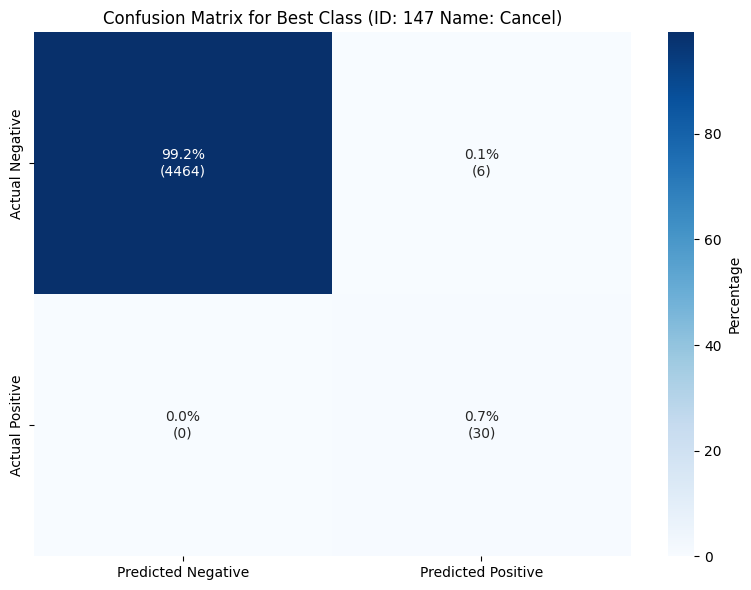

In [34]:
plot_binary_confusion_matrix(
        best_class['confusion_matrix'],
        title=f'Confusion Matrix for Best Class (ID: {best_class["class_id"] } Name: Cancel)'
    )

In [39]:
worst_class = roberta_results['selected_confusion_matrices']['worst_class']
print(f"Class ID:   {worst_class['class_id']}")
print(f"Accuracy:   {worst_class['accuracy']:.4f}")
print(f"Precision:  {worst_class['precision']:.4f}")
print(f"Recall:     {worst_class['recall']:.4f}")
print(f"Support:    {worst_class['support']}")

Class ID:   46
Accuracy:   0.7667
Precision:  1.0000
Recall:     0.7667
Support:    30


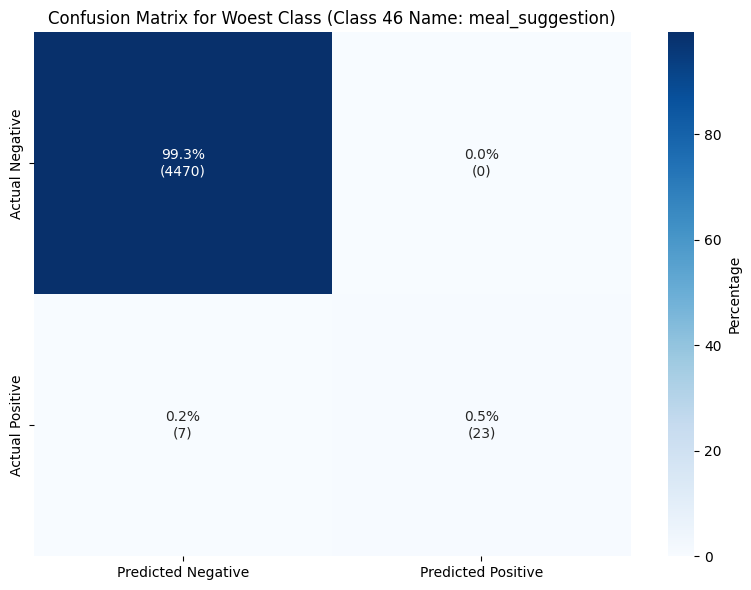

In [40]:
plot_binary_confusion_matrix(worst_class['confusion_matrix'], 
                           title=f'Confusion Matrix for Worst Accuracy Class (Class {worst_class_id} Name: meal_suggestion)')

Let us do the same for Multinomial Naive Bayes. Note that we tuned the alpha value to 0.1 in hyperparameter tuning section of NB, thus, we now can re-implement NB with alpha set to 0.1, train on training + validation combined, and test on test data.

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from tqdm import tqdm

def train_and_evaluate_nb(X_train, X_val, X_test, y_train, y_val, y_test, alpha=0.1):
    """
    Train Multinomial NB on train+val data and evaluate on test data.
    Returns metrics matching the format of our RoBERTa evaluation.
    
    Args:
        X_train, X_val, X_test: Feature matrices
        y_train, y_val, y_test: Labels
        alpha: Smoothing parameter for MultinomialNB
    
    Returns:
        dict: Dictionary containing evaluation metrics and confusion matrices
    """
    # Combine train and validation sets
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    # Initialize and train the model
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_val, y_train_val)
    
    # Get predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate overall metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro': recall_score(y_test, y_pred, average='macro')
    }
    
    # Calculate full confusion matrix
    full_cm = confusion_matrix(y_test, y_pred)
    metrics['full_confusion_matrix'] = full_cm
    
    # Calculate per-class metrics
    unique_classes = np.unique(y_test)
    class_metrics = []
    
    for class_id in unique_classes:
        # Get indices for this class
        class_mask = (y_test == class_id)
        
        if np.any(class_mask):
            # Calculate metrics for this class
            class_preds = y_pred[class_mask]
            class_true = y_test[class_mask]
            
            class_acc = accuracy_score(class_true, class_preds)
            class_precision = precision_score(y_test == class_id, y_pred == class_id)
            class_recall = recall_score(y_test == class_id, y_pred == class_id)
            
            class_metrics.append({
                'class_id': class_id,
                'accuracy': class_acc,
                'precision': class_precision,
                'recall': class_recall,
                'support': np.sum(class_mask)
            })
    
    # Sort classes by accuracy
    sorted_classes = sorted(class_metrics, key=lambda x: x['accuracy'])
    
    # Get worst, middle, and best performing classes
    worst_class = sorted_classes[0]
    middle_class = sorted_classes[len(sorted_classes)//2]
    best_class = sorted_classes[-1]
    
    # Calculate binary confusion matrices for selected classes
    def get_binary_confusion_matrix(true_labels, pred_labels, target_class):
        """Convert multi-class labels to binary for one specific class"""
        true_binary = (true_labels == target_class).astype(int)
        pred_binary = (pred_labels == target_class).astype(int)
        return confusion_matrix(true_binary, pred_binary)
    
    # Store selected class information
    selected_cms = {
        'worst_class': {
            'class_id': worst_class['class_id'],
            'accuracy': worst_class['accuracy'],
            'precision': worst_class['precision'],
            'recall': worst_class['recall'],
            'support': worst_class['support'],
            'confusion_matrix': get_binary_confusion_matrix(y_test, y_pred, worst_class['class_id'])
        },
        'middle_class': {
            'class_id': middle_class['class_id'],
            'accuracy': middle_class['accuracy'],
            'precision': middle_class['precision'],
            'recall': middle_class['recall'],
            'support': middle_class['support'],
            'confusion_matrix': get_binary_confusion_matrix(y_test, y_pred, middle_class['class_id'])
        },
        'best_class': {
            'class_id': best_class['class_id'],
            'accuracy': best_class['accuracy'],
            'precision': best_class['precision'],
            'recall': best_class['recall'],
            'support': best_class['support'],
            'confusion_matrix': get_binary_confusion_matrix(y_test, y_pred, best_class['class_id'])
        }
    }
    
    metrics['selected_confusion_matrices'] = selected_cms
    metrics['class_metrics'] = sorted_classes
    
    return metrics


nb_results = train_and_evaluate_nb(X_train, X_val, X_test, y_train, y_val, y_test, alpha=0.1)

# Print overall metrics
print("Overall Metrics:")
print(f"Accuracy: {nb_results['accuracy']:.4f}")
print(f"F1 Score (Macro): {nb_results['f1_macro']:.4f}")
print(f"Precision (Macro): {nb_results['precision_macro']:.4f}")
print(f"Recall (Macro): {nb_results['recall_macro']:.4f}")



Overall Metrics:
Accuracy: 0.8162
F1 Score (Macro): 0.8127
Precision (Macro): 0.8273
Recall (Macro): 0.8162


In [73]:
with open('/kaggle/input/id2label/id2label.json', 'r') as file:
    label_to_id = json.load(file)

In [75]:
# Function to map a label name to its corresponding ID
def get_label_id(label_name):
    return label_to_id.get(label_name, None)  # Returns None if label_name is not found


label_name = "mpg"
label_id = get_label_id(label_name)
print(label_id)

142


In [64]:
# Print best class metrics
best_class = nb_results['selected_confusion_matrices']['best_class']
print("\nBest Class Metrics (Class ID: {})".format(best_class['class_id']))
print(f"Accuracy: {best_class['accuracy']:.4f}")
print(f"Precision: {best_class['precision']:.4f}")
print(f"Recall: {best_class['recall']:.4f}")

# Print worst class metrics
worst_class = nb_results['selected_confusion_matrices']['worst_class']
print("\nWorst Class Metrics (Class ID: {})".format(worst_class['class_id']))
print(f"Accuracy: {worst_class['accuracy']:.4f}")
print(f"Precision: {worst_class['precision']:.4f}")
print(f"Recall: {worst_class['recall']:.4f}")


Best Class Metrics (Class ID: whisper_mode)
Accuracy: 1.0000
Precision: 0.9375
Recall: 1.0000

Worst Class Metrics (Class ID: change_user_name)
Accuracy: 0.1333
Precision: 0.4444
Recall: 0.1333


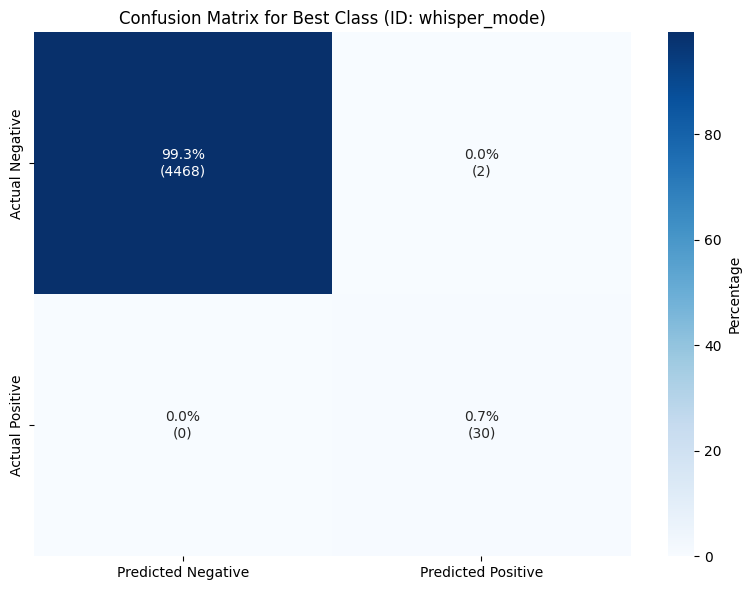

In [68]:
plot_binary_confusion_matrix(
        best_class['confusion_matrix'],
        title=f'Confusion Matrix for Best Class (ID: {best_class["class_id"] })'
    )

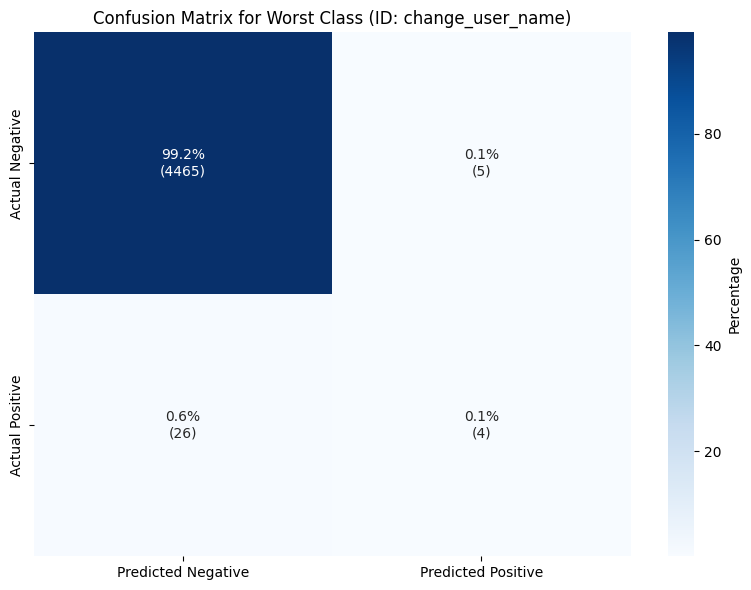

In [71]:
plot_binary_confusion_matrix(
        worst_class['confusion_matrix'],
        title=f'Confusion Matrix for Worst Class (ID: {worst_class["class_id"] })'
    )

Let us also get our best FastText model, and calculate its accuracy, F1 etc.

We first need a new function that also returns the precision and recall score as well.

In [25]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)
import numpy as np

def extended_accuracy_test(model_name, model, validation_file_path):
    """
    Calculate evaluation metrics for a FastText model on a validation dataset.

    Parameters:
        model_name (str): Name of the model being evaluated.
        model: The FastText model object.
        validation_file_path (str): Path to the validation dataset file.

    Returns:
        dict: A dictionary containing overall metrics, per-class metrics, 
              and confusion matrices.
    """
    true_labels = []
    predicted_labels = []

    # Read the validation file
    with open(validation_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Each line is in the format: "__label__intent query"
            parts = line.strip().split(' ', 1)
            true_label = parts[0]  # The label is the first part
            query = parts[1] if len(parts) > 1 else ""  # The query is the rest
            true_labels.append(true_label)

            # Predict the label using the FastText model
            prediction = model.predict(query)[0][0]  # Get the top predicted label
            predicted_labels.append(prediction)

    # Calculate overall metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)
    cm = confusion_matrix(true_labels, predicted_labels)

    # Detailed classification report
    class_report = classification_report(true_labels, predicted_labels, output_dict=True)

    # Identify best and worst performing classes
    class_metrics = []
    for label, metrics in class_report.items():
        if label not in {"accuracy", "macro avg", "weighted avg"}:
            class_metrics.append({
                "class": label,
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1-score": metrics["f1-score"],
                "support": metrics["support"]
            })

    # Sort by F1-score
    sorted_classes = sorted(class_metrics, key=lambda x: x["f1-score"])
    worst_class = sorted_classes[0]
    best_class = sorted_classes[-1]

    # Get confusion matrix for best and worst classes
    label_indices = {label: idx for idx, label in enumerate(set(true_labels))}
    cm_best_class = get_binary_confusion_matrix(true_labels, predicted_labels, best_class["class"], label_indices)
    cm_worst_class = get_binary_confusion_matrix(true_labels, predicted_labels, worst_class["class"], label_indices)

    # Add confusion matrices to class dictionaries
    best_class["confusion_matrix"] = cm_best_class
    worst_class["confusion_matrix"] = cm_worst_class

    # Print results
    print(f"Results for Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    # print("\nClassification Report:")
    # print(classification_report(true_labels, predicted_labels))

    # Return all metrics
    return {
        "overall_metrics": {
            "accuracy": accuracy,
            "f1_macro": f1,
            "precision_macro": precision,
            "recall_macro": recall
        },
        "confusion_matrix": cm,
        "class_metrics": class_metrics,
        "best_class": best_class,
        "worst_class": worst_class
    }


def get_binary_confusion_matrix(true_labels, predicted_labels, target_class, label_indices):
    """
    Convert multi-class confusion matrix to binary for a specific class.

    Parameters:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        target_class (str): Target class for binary confusion matrix.
        label_indices (dict): Mapping of class labels to indices.

    Returns:
        np.ndarray: Binary confusion matrix for the target class.
    """
    target_index = label_indices[target_class]
    true_binary = np.array([1 if label == target_class else 0 for label in true_labels])
    pred_binary = np.array([1 if label == target_class else 0 for label in predicted_labels])
    return confusion_matrix(true_binary, pred_binary)



In [82]:
fasttext_results = extended_accuracy_test("Tokenized Best Model with Test Data", final_model, tokenized_test_file_path) # Test on test

Results for Model: Tokenized Best Model with Test Data
Accuracy: 0.9007
F1 Score (Macro): 0.9002
Precision (Macro): 0.9053
Recall (Macro): 0.9007


In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_for_classes(class_data):
    """
    Plot the confusion matrix for a specific class.

    Parameters:
        class_data (dict): Dictionary containing class details, including:
                           - "class": The class name or label
                           - "confusion_matrix": The binary confusion matrix for the class
    """
    class_name = class_data["class"].replace("__label__", "").strip()
    binary_cm = class_data["confusion_matrix"]

    # Plot the binary confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    display = ConfusionMatrixDisplay(
        confusion_matrix=binary_cm,
        display_labels=["Not " + class_name, class_name]
    )
    display.plot(ax=ax, cmap="Blues")
    plt.title(f"Confusion Matrix for Class: {class_name}")
    plt.show()



In [89]:
confusion_matrix = fasttext_results["confusion_matrix"]

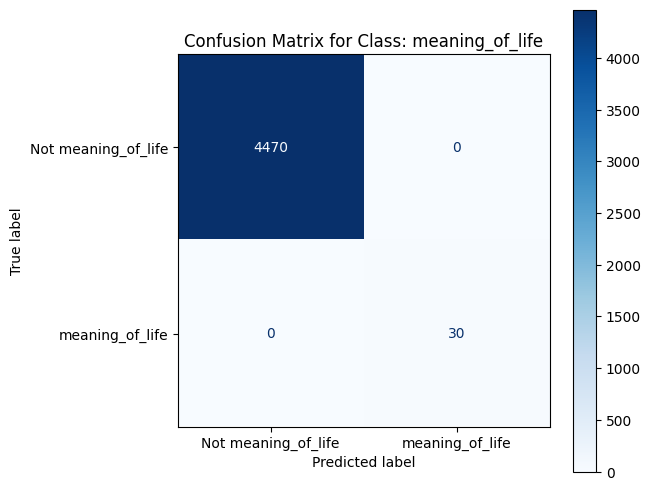

In [90]:
best_class = fasttext_results['best_class']
plot_confusion_matrix_for_classes(best_class)

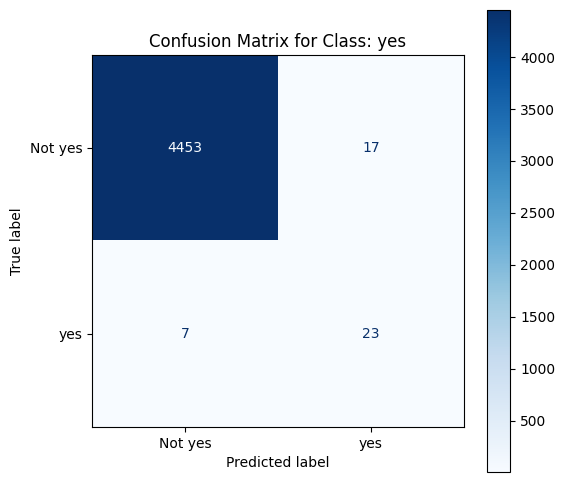

In [91]:
worst_class = fasttext_results['worst_class']
plot_confusion_matrix_for_classes(worst_class)

Note That here we are just adding the results as arrays, but these can be checked from the cells results above. The values are correct and NOT changed.

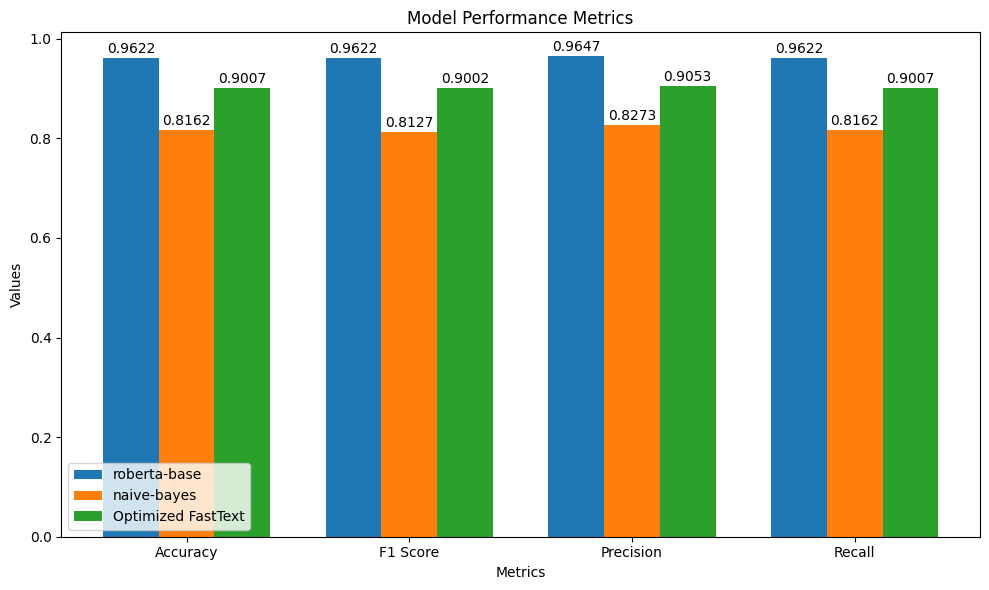

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics data
models = ['roberta-base', 'naive-bayes', 'Tokenized Best']
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
roberta_metrics = [0.9622, 0.9622, 0.9647, 0.9622]
naive_bayes_metrics = [0.8162, 0.8127, 0.8273, 0.8162]
tokenized_best_metrics = [0.9007, 0.9002, 0.9053, 0.9007]

# Data for plotting
x = np.arange(len(metrics))  # Metric positions
width = 0.25  # Bar width

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, roberta_metrics, width, label='roberta-base')
ax.bar(x, naive_bayes_metrics, width, label='naive-bayes')
ax.bar(x + width, tokenized_best_metrics, width, label='Optimized FastText')

# Customization
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate values on bars
for i, v in enumerate(roberta_metrics):
    ax.text(x[i] - width, v + 0.01, f'{v:.4f}', ha='center')
for i, v in enumerate(naive_bayes_metrics):
    ax.text(x[i], v + 0.01, f'{v:.4f}', ha='center')
for i, v in enumerate(tokenized_best_metrics):
    ax.text(x[i] + width, v + 0.01, f'{v:.4f}', ha='center')

# Show plot
plt.tight_layout()
plt.show()



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


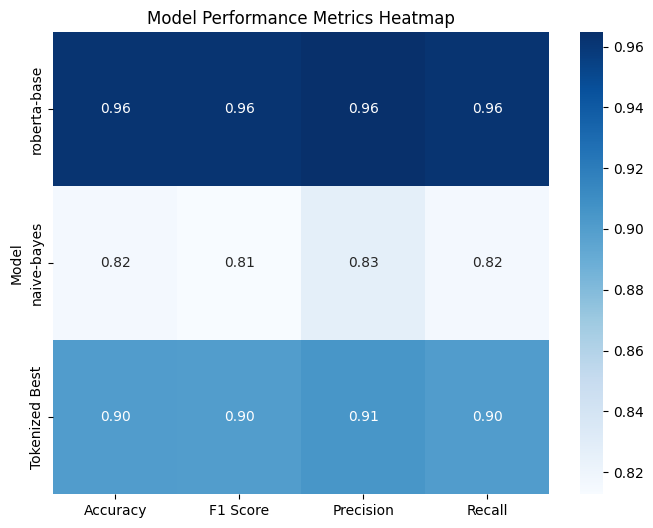

In [98]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data for heatmap
data = {
    'Model': ['roberta-base', 'naive-bayes', 'Tokenized Best'],
    'Accuracy': [0.9622, 0.8162, 0.9007],
    'F1 Score': [0.9622, 0.8127, 0.9002],
    'Precision': [0.9647, 0.8273, 0.9053],
    'Recall': [0.9622, 0.8162, 0.9007]
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(df.set_index('Model'), annot=True, cmap='Blues', fmt='.2f')
plt.title('Model Performance Metrics Heatmap')
plt.show()


### Precision Recall Curves

In [24]:
final_model = fasttext.load_model("fastTextModel/final_model.bin")

In [26]:
fasttext_results = extended_accuracy_test("Tokenized Best Model with Test Data", final_model, tokenized_test_file_path) # Test on test

Results for Model: Tokenized Best Model with Test Data
Accuracy: 0.9007
F1 Score (Macro): 0.9002
Precision (Macro): 0.9053
Recall (Macro): 0.9007


In [57]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score

def extended_accuracy_test(model_name, model, validation_file_path):
    true_labels = []
    predicted_labels = []
    validation_queries = []

    # 1. Collect all queries and true labels
    with open(validation_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            true_label = parts[0]
            query = parts[1] if len(parts) > 1 else ""
            true_labels.append(true_label)
            validation_queries.append(query)

    # 2. Predict and store top label + probabilities
    all_classes = sorted(list(set(true_labels)))
    class_to_idx = {c: i for i, c in enumerate(all_classes)}
    num_classes = len(all_classes)

    y_score = np.zeros((len(validation_queries), num_classes))

    for i, query in enumerate(validation_queries):
        # Get all labels & probabilities
        labels, probs = model.predict(query, k=-1)
        
        # Store into our predicted-probs matrix
        for l, p in zip(labels, probs):
            c_idx = class_to_idx[l]
            y_score[i, c_idx] = p

        # Also store top predicted label
        predicted_labels.append(labels[0])  # top label

    

   
    accuracy = accuracy_score(true_labels, predicted_labels)
   

    # 3. For plotting PR curves, binarize the true labels
    y_true_binarized = label_binarize(
        [class_to_idx[label] for label in true_labels],
        classes=range(num_classes)
    )

    # 4. Plot micro-average PR curve
    precision_micro, recall_micro, _ = precision_recall_curve(
        y_true_binarized.ravel(), 
        y_score.ravel()
    )
    avg_precision_micro = average_precision_score(y_true_binarized, y_score, average="micro")
    plt.figure()
    plt.plot(recall_micro, precision_micro,label = "FastText"  )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Micro-Averaged Precision-Recall Curve")
    plt.legend()
    plt.show()



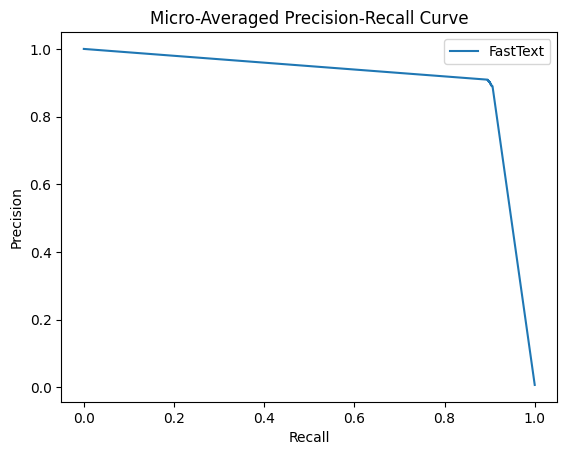

In [58]:
extended_accuracy_test("Tokenized Best Model with Test Data", final_model, tokenized_test_file_path)

In [35]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Initialize and train the model
model = MultinomialNB(alpha=0.1)
model.fit(X_train_val, y_train_val)

# Get predictions on test set
y_pred = model.predict(X_test)

# Calculate performance metrics
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted for multiclass
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted') 
# Print the metrics
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


F1 Score: 0.8127102721864325
Accuracy: 0.8162222222222222
Precision: 0.8273405716167573
Recall: 0.8162222222222222


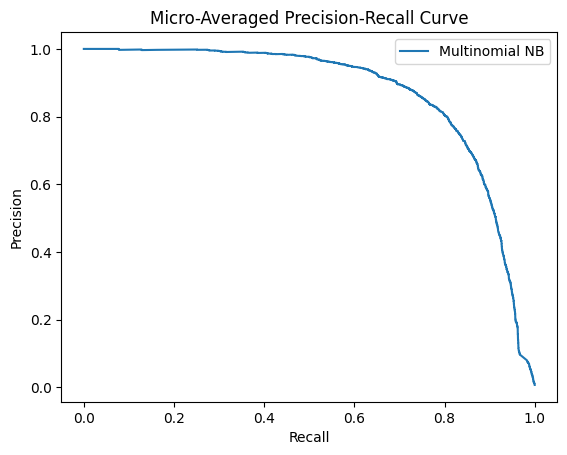

In [60]:
# Get predicted probabilities for the test set
y_proba = model.predict_proba(X_test)

# For multiclass, use the micro-average approach
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize y_test for multiclass problems
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)

# Compute precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test_binarized.ravel(), y_proba.ravel())
average_precision = average_precision_score(y_test_binarized, y_proba, average='micro')

# Plot the curve
plt.figure()
plt.plot(recall, precision, label = "Multinomial NB" ) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


### For Finetuned RoBERTa

In [66]:
from datasets import load_dataset, DatasetDict
dataset = load_dataset("clinc/clinc_oos", "plus")
def filter_intent(example):
    return example['intent'] != 42

# Apply the filter function to each split to remove OOS queries
dataset = DatasetDict({
    split: dataset[split].filter(filter_intent)
    for split in dataset
})
# Now we need to update the labels so that our model does not give an error. 
def update_intent(example):
    if example['intent'] == 150:
        example['intent'] = 42
    return example

dataset = DatasetDict({
    split: dataset[split].map(update_intent)
    for split in dataset
})
dataset
dataset['train'] = dataset['train'].rename_column('intent', 'label')
dataset['validation'] = dataset['validation'].rename_column('intent', 'label')
dataset['test'] = dataset['test'].rename_column('intent', 'label')

In [67]:
dataset['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 4500
})

In [69]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer


model_directory = "/kaggle/working/fine_tuned_roberta"

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_directory, from_tf=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory, from_tf=True)
import tensorflow as tf
import numpy as np
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

# Apply tokenization to the dataset
dataset = dataset.map(tokenize, batched=True)

# Set the format and specify which columns to keep
keep_columns = ["input_ids", "attention_mask", "label"]
dataset.set_format("numpy", columns=keep_columns)

# Define batch size
BATCH_SIZE = 16

# Function to convert HF dataset to TF dataset
def to_tf_dataset(hf_dataset, shuffle=False):
    """Convert a Hugging Face Dataset split into a tf.data.Dataset (features, label)."""
    input_ids = hf_dataset["input_ids"]
    attention_mask = hf_dataset["attention_mask"]
    labels = hf_dataset["label"]
    
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        },
        labels
    ))
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(BATCH_SIZE)
    return ds

# Create TF datasets
train_tf_dataset = to_tf_dataset(dataset["train"], shuffle=True)
val_tf_dataset = to_tf_dataset(dataset["validation"], shuffle=False)
test_tf_dataset = to_tf_dataset(dataset["test"], shuffle=False)

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


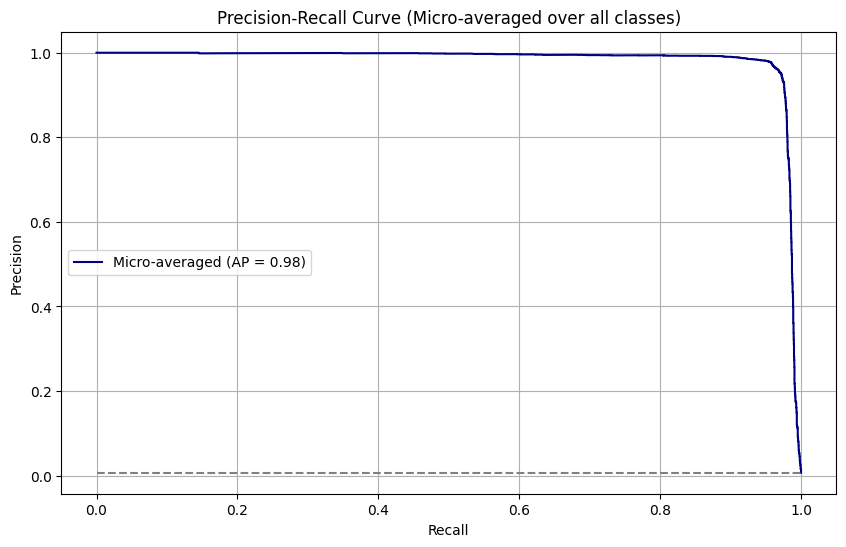


Average Precision Scores per class:


TypeError: '<' not supported between instances of 'str' and 'int'

In [73]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
# Get predictions for test set
def get_predictions(model, dataset):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in dataset:
            # Convert TF tensors to numpy then to PyTorch tensors
            input_ids = torch.tensor(features['input_ids'].numpy())
            attention_mask = torch.tensor(features['attention_mask'].numpy())
            
            # Get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Convert logits to probabilities using softmax
            probabilities = F.softmax(logits, dim=1).numpy()
            
            all_predictions.append(probabilities)
            all_labels.append(labels.numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(all_predictions, axis=0)
    true_labels = np.concatenate(all_labels, axis=0)
    
    return predictions, true_labels

# Get predictions
predictions, true_labels = get_predictions(model, test_tf_dataset)

# Calculate precision-recall curves for each class
n_classes = predictions.shape[1]
precision = dict()
recall = dict()
average_precision = dict()

# Calculate PR curve for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        (true_labels == i).astype(int),
        predictions[:, i]
    )
    average_precision[i] = average_precision_score(
        (true_labels == i).astype(int),
        predictions[:, i]
    )

# Calculate micro-averaged PR curve
y_true = tf.keras.utils.to_categorical(true_labels, num_classes=n_classes)
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true.ravel(),
    predictions.ravel()
)
average_precision["micro"] = average_precision_score(
    y_true.ravel(),
    predictions.ravel(),
    average="micro"
)

# Plot the micro-averaged Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(
    recall["micro"],
    precision["micro"],
    color='navy',
    label=f'Micro-averaged (AP = {average_precision["micro"]:.2f})'
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Micro-averaged over all classes)')
plt.legend(loc='best')
plt.grid(True)

# Add the random performance line
plt.plot([0, 1], [sum(y_true).sum()/len(y_true.ravel()), sum(y_true).sum()/len(y_true.ravel())], 
         linestyle='--', color='gray', label='Random')

plt.show()

# Print average precision for each class
print("\nAverage Precision Scores per class:")
for i in sorted(average_precision.keys()):
    if i != "micro":
        print(f"Class {i}: {average_precision[i]:.3f}")
print(f"\nMicro-averaged Average Precision: {average_precision['micro']:.3f}")
